In [27]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as pl
from apriori import Apriori
from time import time
from helper import GetItemsetFromFile, GetSubsectionOfData, SplitDataIntoChunks, PrintTimeInfo, CreatePairDataFrame

In [2]:
# Get the retail data set
s_t = time()
retail_data = GetItemsetFromFile("retail.data")
f_t = time()
print("Time taken to read retail data: %.2f seconds" % (f_t - s_t))

Time taken to read retail data: 0.23 seconds


In [3]:
support = 0.05 # 5%

In [4]:
 def SON(data_list, data_percentage, support):   
    data_length = len(data_list)
    data_length = math.floor(data_length * data_percentage)
    partial_data = []
    did_not_divide_nicely = False
    num_iterations = int(100 / (data_percentage * 100))
    list_of_frequent_item_lists = []
    partials = []

    # Remainder after dividing by the fraction
    if data_length % (data_percentage * 100) != 0:
        did_not_divide_nicely = True
        # Left overs is the remainder after dividing
        # In the case of 20%, if you round you get 5 data lengths of 17632
        # 17632 * 5 = 88160
        # Actual length of data is 88162
        # This gets the remaining 2 rows we would have missed so we can cover the entire dataset
        leftovers = round(data_length - (math.floor(data_length / num_iterations) * num_iterations))
        
    for i in range(1, num_iterations+1):
        data_size = data_length * i
        # if there was a remainder from division
        if did_not_divide_nicely == True:
            # If it is the last run of the loop
            if i == num_iterations:
                # Add the leftover value to the last pass to get the entire dataset
                data_size += leftovers

        partial_data = GetSubsectionOfData(data_list[data_length * (i-1):data_size], 1)
        partials.append(partial_data)

        # Support is divided by the fraction of data we look at
        occ, freq = Apriori(partial_data, support / num_iterations, 2)
        list_of_frequent_item_lists.append(freq)
    return list_of_frequent_item_lists

In [16]:
support_thresholds = [0.01, 0.02, 0.05]
chunk_sizes = [0.2, .33, 0.5]

In [24]:
son_pair_timings = []
son_pairings = []
for chunk in chunk_sizes:
    for support in support_thresholds:
        s_t = time()    # Start time
        freq = SON(retail_data, chunk, support)
        f_t = time()    # End time
        son_pair_timings.append((f_t - s_t))    # get total time
        son_pairings.append(freq)
        print_title = "SON Apriori with chunk size " + str(int(chunk*100))
        PrintTimeInfo(print_title, 100, (f_t - s_t), support, "pairs")

Time taken to complete SON Apriori with chunk size 20 on 100% of data using pairs of retail data: 129.47 seconds with support: 1%
Time taken to complete SON Apriori with chunk size 20 on 100% of data using pairs of retail data: 50.98 seconds with support: 2%
Time taken to complete SON Apriori with chunk size 20 on 100% of data using pairs of retail data: 13.65 seconds with support: 5%
Time taken to complete SON Apriori with chunk size 33 on 100% of data using pairs of retail data: 62.69 seconds with support: 1%
Time taken to complete SON Apriori with chunk size 33 on 100% of data using pairs of retail data: 23.68 seconds with support: 2%
Time taken to complete SON Apriori with chunk size 33 on 100% of data using pairs of retail data: 8.56 seconds with support: 5%
Time taken to complete SON Apriori with chunk size 50 on 100% of data using pairs of retail data: 33.72 seconds with support: 1%
Time taken to complete SON Apriori with chunk size 50 on 100% of data using pairs of retail data:

In [32]:
# Run Apriori normally on 100% of data for all 3 support thresholds
apriori_item_pairings = []
for support in support_thresholds:
    s_t = time()
    occ, freq = Apriori(retail_data, support, 2)
    f_t = time()
    apriori_item_pairings.append(freq)
    PrintTimeInfo("Apriori", 100, (f_t - s_t), support, "pairs")

Time taken to complete Apriori on 100% of data using pairs of retail data: 12.79 seconds with support: 1%
Time taken to complete Apriori on 100% of data using pairs of retail data: 6.32 seconds with support: 2%
Time taken to complete Apriori on 100% of data using pairs of retail data: 4.39 seconds with support: 5%


In [34]:
# Count the number of pairs that are in the SON sampling but not in the actual data
false_positives_list = np.zeros((9,1))
for i in range(len(son_pairings)):
    for j in range(len(apriori_item_pairings)):
        for pairing in son_pairings[i]:
            if pairing not in apriori_item_pairings[j]:
                false_positives_list[i] += 1

In [39]:
# Display false positives
i = 0
for chunk_size in chunk_sizes:
    for support in support_thresholds:
        print("False positives for original support threshold %d%% but with %d%% of data is %d." % ((support * 100), (chunk_size * 100), false_positives_list[i]))
        i += 1

False positives for original support threshold 1% but with 20% of data is 15.
False positives for original support threshold 2% but with 20% of data is 15.
False positives for original support threshold 5% but with 20% of data is 15.
False positives for original support threshold 1% but with 33% of data is 9.
False positives for original support threshold 2% but with 33% of data is 9.
False positives for original support threshold 5% but with 33% of data is 9.
False positives for original support threshold 1% but with 50% of data is 6.
False positives for original support threshold 2% but with 50% of data is 6.
False positives for original support threshold 5% but with 50% of data is 6.


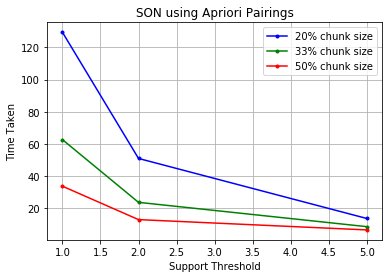

In [38]:
new_sup = [support * 100 for support in support_thresholds]
pl.plot(new_sup, son_pair_timings[0:3], '.-', color='blue', label="20% chunk size")
pl.plot(new_sup, son_pair_timings[3:6], '.-', color='green', label="33% chunk size")
pl.plot(new_sup, son_pair_timings[6:9], '.-', color='red', label="50% chunk size")
pl.legend(loc="upper right")
pl.title("SON using Apriori Pairings")
pl.xlabel("Support Threshold")
pl.ylabel("Time Taken")
pl.grid()
pl.show()